<a href="https://colab.research.google.com/github/binhluong84/Machine-Learning/blob/main/News_Category_Prediction_(Word_Embeddings).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connect Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
data = pd.read_json('/gdrive/MyDrive/News Category Prediction (Word Embeddings)/archive/News_Category_Dataset_v3.json', lines=True)

In [5]:
data

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [7]:
mapping = dict(enumerate(data['category'].unique()))
LABEL_MAPPING = {value: key for key, value in mapping.items()}
LABEL_MAPPING

{'U.S. NEWS': 0,
 'COMEDY': 1,
 'PARENTING': 2,
 'WORLD NEWS': 3,
 'CULTURE & ARTS': 4,
 'TECH': 5,
 'SPORTS': 6,
 'ENTERTAINMENT': 7,
 'POLITICS': 8,
 'WEIRD NEWS': 9,
 'ENVIRONMENT': 10,
 'EDUCATION': 11,
 'CRIME': 12,
 'SCIENCE': 13,
 'WELLNESS': 14,
 'BUSINESS': 15,
 'STYLE & BEAUTY': 16,
 'FOOD & DRINK': 17,
 'MEDIA': 18,
 'QUEER VOICES': 19,
 'HOME & LIVING': 20,
 'WOMEN': 21,
 'BLACK VOICES': 22,
 'TRAVEL': 23,
 'MONEY': 24,
 'RELIGION': 25,
 'LATINO VOICES': 26,
 'IMPACT': 27,
 'WEDDINGS': 28,
 'COLLEGE': 29,
 'PARENTS': 30,
 'ARTS & CULTURE': 31,
 'STYLE': 32,
 'GREEN': 33,
 'TASTE': 34,
 'HEALTHY LIVING': 35,
 'THE WORLDPOST': 36,
 'GOOD NEWS': 37,
 'WORLDPOST': 38,
 'FIFTY': 39,
 'ARTS': 40,
 'DIVORCE': 41}

In [8]:
NUM_CLASSES = len(LABEL_MAPPING)
print("# of classes:", NUM_CLASSES)

# of classes: 42


In [9]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=0):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences

In [10]:
def preprocess_inputs(df, label_mapping=None):
    df = df.copy()
    
    # Use only the headline and category columns
    df = df.loc[:, ['headline', 'category']]
    
    # Sample 1000 examples from each category
    category_samples = []
    
    for category in df['category'].unique():
        category_slice = df.query("category == @category")
        category_samples.append(category_slice.sample(1000, random_state=1))
    df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
    
    # Map the labels to integers
    df['category'] = df['category'].replace(label_mapping)
    
    # Split df into X and y
    y = df['category']
    X = df['headline']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Fit a tokenizer
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train)
    
    # Get sequence data
    X_train = get_sequences(X_train, tokenizer, train=True)
    X_test = get_sequences(X_test, tokenizer, train=False, max_seq_length=X_train.shape[1])
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, label_mapping=LABEL_MAPPING)

In [13]:
X_train.shape

(29399, 26)

In [14]:
y_train

10895    41
2087     18
35565    35
4351      0
22265    35
         ..
7813     33
32511    17
5192     41
12172     4
33003    32
Name: category, Length: 29399, dtype: int64

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 embedding (Embedding)       (None, 26, 64)            640000    
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 128)               213120    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 42)                5418      
                                                                 
Total params: 875,050
Trainable params: 875,050
Non-trainable

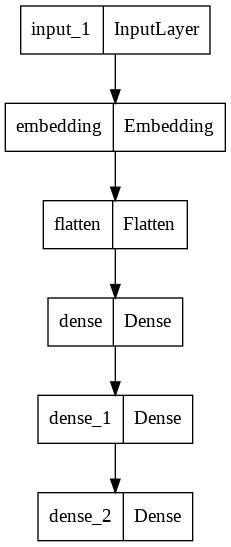

In [15]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

embedding = tf.keras.layers.Embedding(
    input_dim=10000,
    output_dim=64
)(inputs)

flatten = tf.keras.layers.Flatten()(embedding)

dense_1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
dense_2 = tf.keras.layers.Dense(128, activation='relu')(dense_1)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_2)


model = tf.keras.Model(inputs, outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
735/735 [==============================] - 15s 17ms/step - loss: 3.4663 - accuracy: 0.0852 - val_loss: 2.9595 - val_accuracy: 0.2075
Epoch 2/100
735/735 [==============================] - 10s 13ms/step - loss: 2.3104 - accuracy: 0.3644 - val_loss: 2.6026 - val_accuracy: 0.3111
Epoch 3/100
735/735 [==============================] - 10s 13ms/step - loss: 1.2106 - accuracy: 0.6627 - val_loss: 3.0051 - val_accuracy: 0.3282
Epoch 4/100
735/735 [==============================] - 10s 14ms/step - loss: 0.4657 - accuracy: 0.8759 - val_loss: 3.8335 - val_accuracy: 0.3063
Epoch 5/100
735/735 [==============================] - 10s 14ms/step - loss: 0.1632 - accuracy: 0.9602 - val_loss: 4.6607 - val_accuracy: 0.3026


In [17]:
print("Test Accuracy: {:.2f}%".format(model.evaluate(X_test, y_test, verbose=0)[1] * 100))

Test Accuracy: 31.72%


394/394 [==============================] - 2s 5ms/step


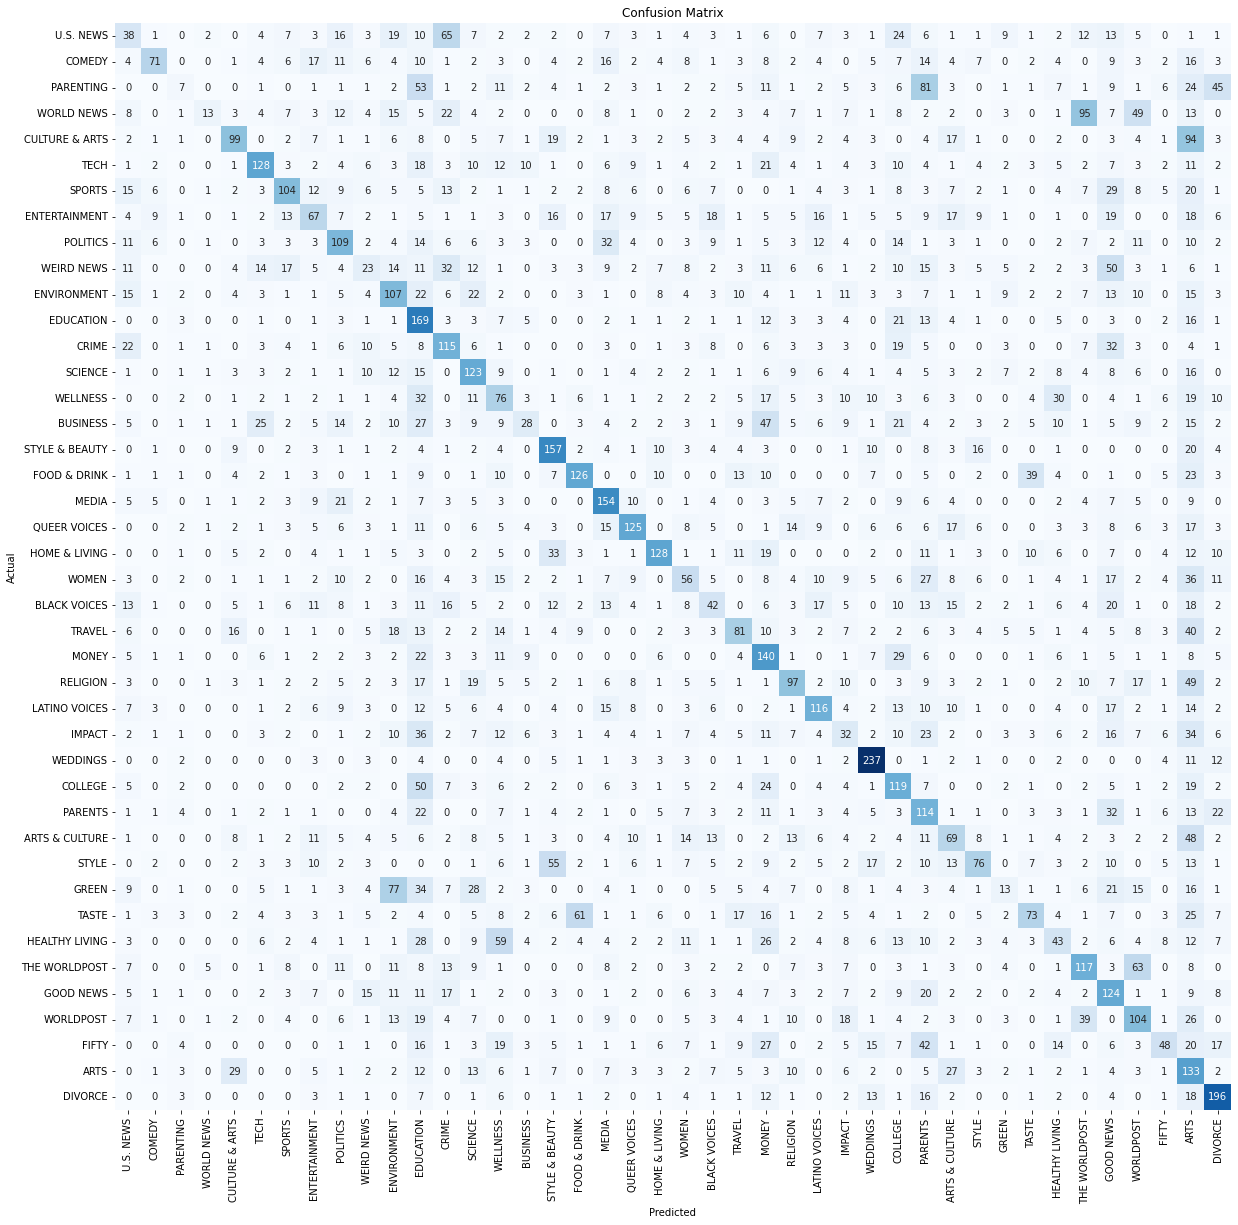

In [18]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=list(LABEL_MAPPING.keys()))

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=list(LABEL_MAPPING.keys()), rotation=90)
plt.yticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=list(LABEL_MAPPING.keys()), rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                 precision    recall  f1-score   support

     U.S. NEWS       0.17      0.13      0.15       293
        COMEDY       0.60      0.26      0.37       270
     PARENTING       0.14      0.02      0.04       309
    WORLD NEWS       0.45      0.04      0.07       319
CULTURE & ARTS       0.47      0.30      0.37       331
          TECH       0.52      0.41      0.46       316
        SPORTS       0.47      0.33      0.38       320
 ENTERTAINMENT       0.30      0.22      0.25       305
      POLITICS       0.36      0.36      0.36       300
    WEIRD NEWS       0.15      0.07      0.10       317
   ENVIRONMENT       0.28      0.34      0.31       317
     EDUCATION       0.21      0.58      0.31       293
         CRIME       0.32      0.40      0.36       287
       SCIENCE       0.33      0.43      0.37       285
      WELLNESS       0.21      0.26      0.23       287
      BUSINESS       0.28      0.09      0.13       315
